# The EM Algorithm for Gaussian Mixtures
### Maks Cegielski-Johnson & Jake Pitkin

**CS 6190: Probabilistic Modeling - Spring 2018**<br>
**April 27 2018**

$2.$ Say you are given data $(X,Y)$, with $X \in \mathbb{R}^d$ and $Y \in \{0,1\}$. The goal is to train a classifier that will predict an unknown class label $\tilde{y}$ from a new data point $\tilde{x}$. Consider the following model:

$$Y \sim Ber\Big(\frac{1}{1+e^{-X^T\beta}}\Big),$$
$$\beta \sim N(0, \sigma^2I).$$

This is a Bayesian logistic regression model. Your goal is to derive and implement a Hamiltonian Monte Carlo sampler for doing Bayesian inference on $\beta$.

**(a)** Write down the formula for the unormalized posterior of $\beta|Y$, i.e.,

$$p(\beta|Y;X,\sigma) \propto \prod_{i=1}^n p(y_i|\beta;x_i)p(\beta;\sigma)$$

We know that $\beta$ comes from a normal distribution with a mean of $0$ and variance of $\sigma^2I$:

$$p(\beta;\sigma) = N(0, \sigma^2I) = \frac{1}{\sqrt{2\pi\sigma^2I}} exp\Big(\frac{-\beta^T\beta}{2\sigma^2I}\Big)$$

The likelihood of a sample $y_i$ comes from a Bernoulli distribution as follows:

$$p(y_i|\beta;x_i) = Ber\Big(\frac{1}{1+e^{-x_i^T\beta}}\Big) = \Big(\frac{1}{1 + exp(-x_i^T\beta)}\Big)^{y_i} * \Big(\frac{exp(-x_i^T\beta)}{1 + exp(-x_i^T\beta)}\Big)^{1 - y_i}$$

Putting the likelihood and prior together we get the unormalized posterior of $\beta|Y$:

$$p(\beta|y;x,\sigma) \propto \prod_{i=1}^n p(y_i|\beta;x_i)p(\beta;\sigma)$$

$$p(\beta|Y;X,\sigma) \propto \prod_{i=1}^n \Big(\frac{1}{1 + exp(-x_i^T\beta)}\Big)^{y_i} * \Big(\frac{exp(-x_i^T\beta)}{1 + exp(-x_i^T\beta)}\Big)^{1 - y_i} * \frac{1}{\sqrt{2\pi\sigma^2I}} exp\Big(\frac{-\beta^T\beta}{2\sigma^2I}\Big)$$

Simplifying by combining the Bernoulli terms:

$$\boxed{p(\beta|Y;X,\sigma) \propto \prod_{i=1}^n \frac{exp(-x_i^T\beta)^{1 - y_i}}{1 + exp(-x_i^T\beta)} * \frac{1}{\sqrt{2\pi\sigma^2I}} exp\Big(\frac{-\beta^T\beta}{2\sigma^2I}\Big)}$$


**(b)** Show that this posterior is proportional to $exp(-U(\beta)))$, where

$$U(\beta) = \sum_{i=1}^n (1 - y_i)x_i^T \beta + log(1 + e^{-x_i^T \beta}) + \frac{1}{2\sigma^2}||\beta||^2$$

Starting with $p(\beta | Y; X, \sigma)$ from part a, we will take the $log$ and the $exp$ later to account for it:

$$p(\beta|Y;X,\sigma) \propto log\Big(\prod_{i=1}^n \frac{exp(-x_i^T\beta)^{1 - y_i}}{1 + exp(-x_i^T\beta)} * \frac{1}{\sqrt{2\pi\sigma^2I}} exp\Big(\frac{-\beta^T\beta}{2\sigma^2I}\Big)\Big)$$

$$p(\beta|Y;X,\sigma) \propto \sum_{i=1}^n -(1 - y_i) x_i^T\beta - log(1 + exp(-x_i^T\beta)) + \frac{1}{\sqrt{2\pi\sigma^2I}} - \frac{\beta^T\beta}{2\sigma^2I}$$

We are interested in showing they are proportional so we can drop the constant terms and $\beta^T\beta = ||\beta||^2$:

$$p(\beta|Y;X,\sigma) \propto \sum_{i=1}^n -(1 - y_i) x_i^T\beta - log(1 + exp(-x_i^T\beta)) - \frac{||\beta||^2}{2\sigma^2}$$

Take the negative and the exponential to show that $exp(log(p(\beta|Y;X,\sigma))) \propto exp(-U(\beta)))$:

$$\boxed{exp(-U(\beta)) \propto p(\beta|Y;X,\sigma) \propto \sum_{i=1}^n (1 - y_i) x_i^T\beta + log(1 + exp(-x_i^T\beta)) + \frac{||\beta||^2}{2\sigma^2}}$$

**(c)** Implement a Hamiltonian Monte Carlo Routine in Python for sampling from the posterior of $\beta$.

For the Monte Carlo Routine we need the gradient of U with respect to $\beta$:

$$\nabla U(\beta) = \frac{d}{d\beta} \sum_{i=1}^n (1 - y_i)x_i^T \beta + log(1 + e^{-x_i^T \beta}) + \frac{1}{2\sigma^2}||\beta||^2$$

$$\nabla U(\beta) = \sum_{i=1}^n (1 - y_i)x_i + \frac{d}{d\beta}  log(1 + e^{-x_i^T \beta}) + \frac{1}{2\sigma^2}||\beta||^2$$

$$\nabla U(\beta) = \sum_{i=1}^n (1 - y_i)x_i + \frac{-x_i e^{-x_i^T \beta}}{e^{-x_i^T\beta } + 1} + \frac{d}{d\beta} \frac{1}{2\sigma^2}||\beta||^2$$

$$\boxed{\nabla U(\beta) = \sum_{i=1}^n (1 - y_i)x_i + \frac{-x_i e^{-x_i^T \beta}}{e^{-x_i^T\beta } + 1} + \frac{\beta}{\sigma^2}}$$

In [7]:
import pandas as pd
import numpy as np
import random

# From the Radford Neal paper - converted from R to Python
def U(beta, samples, sigma):
    energy = 0
    for s in samples:
        energy += (1 - s[1]) * np.dot(s[0], beta)
        energy += np.log(1 + np.exp(np.dot(-1 * s[0], beta)))
        energy += np.linalg.norm(beta)**2 / (2 * sigma**2)
    return energy

def grad_U(beta, samples, sigma):
    # term 1: drop beta
    # term 3: wolfram
    # term 3: 2 beta
    grad = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    for s in samples:
        grad += (1 - s[1]) * s[0]
        grad += ((-1 * s[0]) * np.exp(np.dot(-1 * s[0], beta))) / (np.exp(np.dot(-1 * s[0], beta)) + 1)
        grad += beta * (1/sigma**2)
    return grad

def HMC(epsilon, L, current_beta, samples, sigma):
    beta = current_beta
    p = np.random.normal(0, 1, len(beta))
    current_p = p
    
    # Make a half step for momentum at the beginning
    
    p = p - epsilon * (grad_U(beta, samples, sigma) / 2)
    
    # Alternate full steps for position and momentum
    
    for i in range(L):
        # Make a full step for the position
        
        beta = beta + epsilon * p
        
        # Make a full step for the momentum, except at end of trajectory
        
        if i != L-1:
            p = p - epsilon * grad_U(beta, samples, sigma)
    
    # Make a half step for momentum at the end
    
    p = p - epsilon * (grad_U(beta, samples, sigma) / 2)
    
    # Negate momentum at end of trajectory to make the proposal symmetric
    
    p = -1 * p
    
    # Evalulate potential and kinetic energies at start and end of trajectory
    
    current_U = U(current_beta, samples, sigma)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(beta, samples, sigma)
    proposed_K = np.sum(p**2) / 2
    
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    if np.random.uniform() < np.exp(current_U-proposed_U+current_K-proposed_K):
        return beta # Accept
    else:
        return current_beta # Reject

**(d)** Use your code to analyze the ${\tt iris}$ data in Python, looking only at two species, *versicolor* and *virginica*. The species labels are your $Y$ data, and the four features, petal length and width, sepal length and width, are your $X$ data. Also, add a constant term, i.e., a columns of 1's to your $X$ matrix. Use the first 30 rows for each species as training data and leave out the last $20$ rows for each species as test data (for a total of $60$ training and $40$ testing). Generate samples of $\beta$ (don't forget to burn-in), and use these to get a prediction, $\tilde{y}$, of the class labels for the test data. Use your samples to get a Monte Carlo estimate of the posterior predictive probability $p(\tilde{y}|y)$ for each testing data point.

In [8]:
# Read in the dataset
iris = pd.read_csv("iris.csv")
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']
iris['label'] = iris['label'].replace(['Iris-versicolor', 'Iris-virginica'], [0, 1])

# Create feature vectors and labels
iris_vectors = []
for row in iris.iterrows():
    iris_vectors.append((np.array([1, row[1][0], row[1][1], row[1][2], row[1][3]]), row[1][4]))

# Separate into train and test data
versicolor_train = iris_vectors[0:30]
versicolor_test = iris_vectors[30:50]
virginica_train = iris_vectors[50:80]
virginica_test = iris_vectors[80:100]
train = versicolor_train + virginica_train
test = versicolor_test + virginica_test
random.shuffle(train)
random.shuffle(test)

# Estimate the Beta parameter
samples = 1000
beta = np.array([0, 0, 0, 0, 0])
beta_estimates = []
sigma = 4
L = 10
epsilon = 0.05
for _ in range(samples):
    estimate = HMC(epsilon, L, beta, train, sigma)
    beta_estimates.append(estimate)
    beta = estimate

# Predict to find p(y^~|y) using the final Beta estimate
correct = 0
predictions = []
examples = len(test)
print("Confidence interval for each label prediction:")
for index, s in enumerate(test):
    confidence = 1 / (1 + np.exp(np.dot(-1 * s[0], beta)))
    prediction = 0
    if 0.5 < confidence:
        prediction = 1
        print("Test sample #{}: p({}|{}) = {}".format(index+1, prediction, int(s[1]), confidence))
    else:
        print("Test sample #{}: p({}|{}) = {}".format(index+1, prediction, int(s[1]), 1-confidence))
    if prediction == s[1]:
        correct += 1
    predictions.append(prediction)
print()
print("Accuracy estimate: ", str(correct/examples))

Confidence interval for each label prediction:
Test sample #1: p(1|1) = 0.5412005291985567
Test sample #2: p(1|1) = 0.6355538066146561
Test sample #3: p(0|0) = 0.6711067704089998
Test sample #4: p(0|0) = 0.6126297915398232
Test sample #5: p(0|0) = 0.6295500846200575
Test sample #6: p(0|0) = 0.6269355246816737
Test sample #7: p(0|0) = 0.6786654654873664
Test sample #8: p(0|0) = 0.642187740012103
Test sample #9: p(0|0) = 0.6066421951739284
Test sample #10: p(0|1) = 0.5497331738504964
Test sample #11: p(0|0) = 0.7091276971306995
Test sample #12: p(1|1) = 0.6689518434301415
Test sample #13: p(1|1) = 0.566319970635669
Test sample #14: p(0|1) = 0.5453600161799683
Test sample #15: p(1|1) = 0.591352269962571
Test sample #16: p(1|1) = 0.5141735003239087
Test sample #17: p(0|0) = 0.6835124279744713
Test sample #18: p(1|1) = 0.594896203336774
Test sample #19: p(1|1) = 0.5697467529162301
Test sample #20: p(1|1) = 0.6936002848533694
Test sample #21: p(0|0) = 0.601563367895743
Test sample #22: p(0|0

**(e)** Draw trace plots of your $\beta$ sequence and histograms (do 1D plots of each four vector components separately).

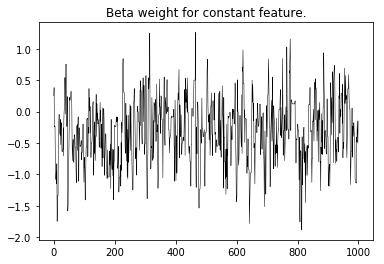

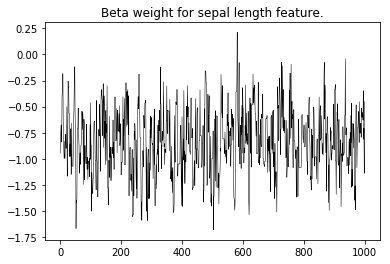

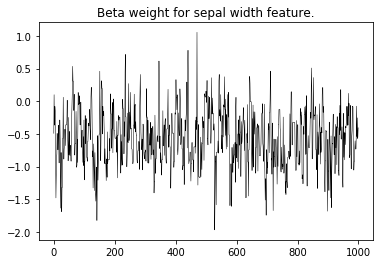

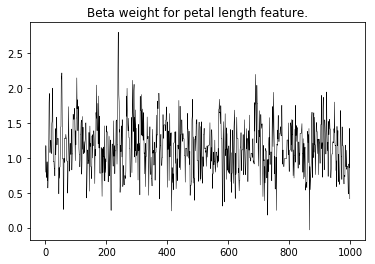

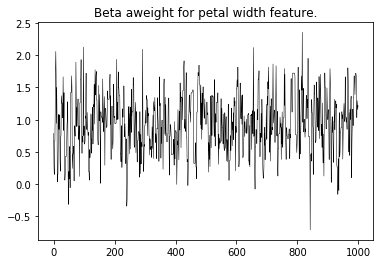

In [9]:
plt.figure()
plt.title("Beta weight for constant feature.")
plt.plot([row[0] for row in beta_estimates], color='black', linestyle='solid', linewidth=0.5)
plt.figure()
plt.title("Beta weight for sepal length feature.")
plt.plot([row[1] for row in beta_estimates], color='black', linestyle='solid', linewidth=0.5)
plt.figure()
plt.title("Beta weight for sepal width feature.")
plt.plot([row[2] for row in beta_estimates], color='black', linestyle='solid', linewidth=0.5)
plt.figure()
plt.title("Beta weight for petal length feature.")
plt.plot([row[3] for row in beta_estimates], color='black', linestyle='solid', linewidth=0.5)
plt.figure()
plt.title("Beta aweight for petal width feature.")
plt.plot([row[4] for row in beta_estimates], color='black', linestyle='solid', linewidth=0.5)
plt.show()

**(f)** Compare this to the true class labels, $y$, and see how well you did by estimating the average error rate, $E[|y - \tilde{y}|]$ (a.k.a. the zero-one loss). What values of $\sigma$, $\epsilon$, and $L$ did you use?

In [11]:
# Compute the zero-one loss or 
loss = 0
print("sigma = 4")
print("epsilon = 0.05")
print("L = 10")
print()
for index, s in enumerate(test):
    loss += abs(s[1] - predictions[index])
print("Correct labels: {}".format(len(predictions) - loss))
print("Incorrect labels: {}".format(loss))
print()
print("Zero-one loss for predicted labels: {}".format(loss/len(predictions)))

sigma = 4
epsilon = 0.05
L = 10

Correct labels: 37.0
Incorrect labels: 3.0

Zero-one loss for predicted labels: 0.075
